# Neural Network from Scratch Using PyTorch and Custom Dataset

# **Activity: Build a student pass/fail classifier**
Build and train a neural network to predict whether a student will pass or fail based on their study hours and attendance rate.

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader, random_split

In [11]:

csv_path = "data/student_data.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    # generate synthetic data if none provided
    rng = np.random.default_rng(42)
    n = 500
    study_hours = rng.uniform(0, 10, n)
    attendance_rate = rng.uniform(0.4, 1.0, n)
    linear_score = 0.6*study_hours + 0.9*(attendance_rate*10)
    noise = rng.normal(0, 1.5, n)
    y = ((linear_score + noise) > 7.5).astype(int)
    df = pd.DataFrame({"study_hours": study_hours,
                       "attendance_rate": attendance_rate,
                       "pass": y})
    os.makedirs("data", exist_ok=True)
    df.to_csv(csv_path, index=False)

display(df.describe())


,study_hours,attendance_rate,pass
count,500.000000,500.000000,500.000000
mean,4.956813,0.699205,0.742000
std,2.867725,0.177960,0.437972
min,0.054298,0.400740,0.000000
25%,2.359816,0.545991,0.000000
50%,5.008930,0.696229,1.000000
75%,7.472442,0.858027,1.000000
max,9.991047,0.999246,1.000000


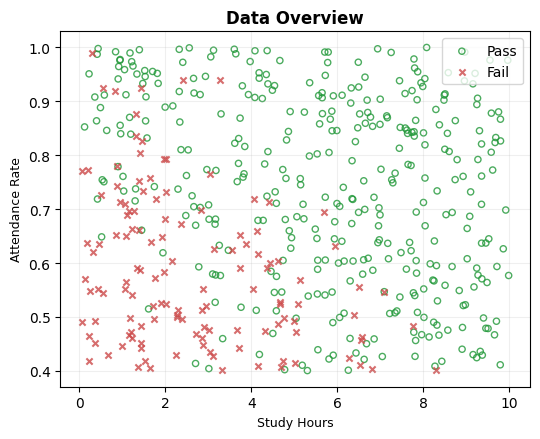

In [12]:
plt.figure(figsize=(5.5, 4.5))
mask = df["pass"]==1

plt.scatter(df.loc[mask,"study_hours"], df.loc[mask,"attendance_rate"], s=20, alpha=0.8, label="Pass", facecolors='none', edgecolors="#1f9737")
plt.scatter(df.loc[~mask,"study_hours"], df.loc[~mask,"attendance_rate"], s=20, alpha=0.8, label="Fail", color="#cc4949", marker='x')

plt.xlabel("Study Hours", size=9)
plt.ylabel("Attendance Rate", size=9)
plt.title("Data Overview", fontweight='bold')

plt.grid(True, alpha=0.2)

plt.legend(); plt.tight_layout(); plt.show()

This code block handles the entire data pipeline, starting by converting the "study\_hours" and "attendance\_rate" features (`X`) and the "pass" label (`y`) from a Pandas DataFrame into NumPy arrays, and then into PyTorch **Tensors**, which is the required format for the model. <br><br>It then zips these tensors together into a `TensorDataset` and uses `random_split` to divide all the data into an **80% training set** and a **20% testing set**. <br><br>The `manual_seed(42)` is crucial here, as it guarantees this "random" split is **reproducible**, meaning the *exact same* data points end up in the train and test sets every time you run the code. <br><br>Finally, it wraps these new datasets in `DataLoader` objects, which will feed the data to the model in small, manageable **batches of 32**. The `train_loader` uses `shuffle=True` to randomly mix the data each epoch to help the model generalize, while the `test_loader` uses `shuffle=False` to provide a consistent benchmark for evaluation.

In [13]:
X_np = df[["study_hours", "attendance_rate"]].to_numpy(dtype=np.float32, copy=True)
y_np = df[["pass"]].to_numpy(dtype=np.float32, copy=True)

X = torch.from_numpy(X_np).to(torch.float32)
y = torch.from_numpy(y_np).to(torch.float32)

dataset = TensorDataset(X, y)

n_train = int(0.8 * len(dataset))
n_test = len(dataset) - n_train
train_ds, test_ds = random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

This class `StudentNet` contains a simple neural network. This specific type of network is a binary classifier. It's designed to take 2 input features (like your "study_hours" and "attendance_rate") and output a single number between 0 and 1, representing the probability of a "pass."

In [14]:
class StudentNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 8), nn.ReLU(),
            nn.Linear(8, 4), nn.ReLU(),
            nn.Linear(4, 1), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

model = StudentNet()

This code block sets up the two most important tools for the training process: the loss function and the optimizer. The criterion measure how wrong your model's predictions are compared to the actual, true labels. While, optimizer fixes the error found by criterion. It's the engine that drives the learning process. It looks at the error and "nudges" all of your model's internal parameters (its weights) in the correct direction to make the error smaller.

In [15]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

This code block is the engine for training the `StudentNet` model. It runs the model for a set number of epochs–300 in this case, trains it on the train_loader, and evaluates its performance on the test_loader after each epoch.

In [16]:
def bin_acc(p_hat, y_true):
    preds = (p_hat >= 0.5).float()
    return (preds == y_true).float().mean().item()

n_epochs = 300
train_losses, train_accs, test_accs = [], [], []

for epoch in range(1, n_epochs+1):
    model.train()
    epoch_loss, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        correct += ((out >= 0.5).float() == yb).sum().item()
        total += yb.numel()

    train_losses.append(epoch_loss/total)
    train_accs.append(correct/total)

    # test each epoch
    model.eval()
    with torch.no_grad():
        c, t = 0, 0
        for xb, yb in test_loader:
            out = model(xb)
            c += ((out >= 0.5).float() == yb).sum().item()
            t += yb.numel()
        test_accs.append(c/t)

print(f"Final Train Acc: {train_accs[-1]:.3f} | Final Test Acc: {test_accs[-1]:.3f}")


Final Train Acc: 0.850 | Final Test Acc: 0.850


This code gathers all your test data into one group. Instead of testing in small batches, it runs the **entire test set** through the model at one time to get all the final predictions. It then compares those predictions to the correct answers to calculate and print the final test accuracy.

In [17]:
model.eval()
with torch.no_grad():
    X_test = torch.stack([b[0] for b in test_ds])
    y_test = torch.stack([b[1] for b in test_ds])
    y_prob = model(X_test).squeeze(1)
    y_pred = (y_prob >= 0.5).float()
    test_accuracy = (y_pred == y_test.squeeze(1)).float().mean().item()

print({"test_accuracy": test_accuracy})

{'test_accuracy': 0.8500000238418579}


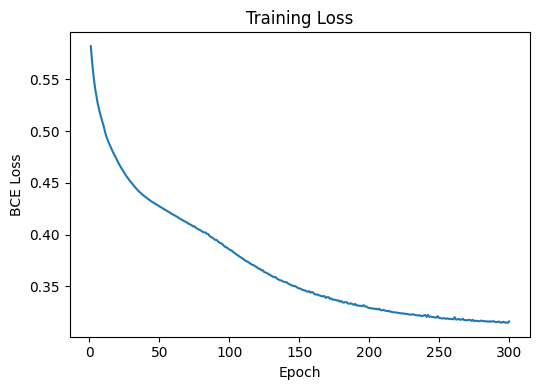

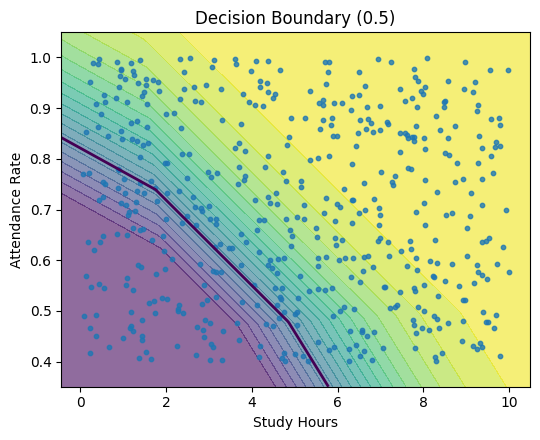

In [18]:
# loss curve
plt.figure(figsize=(5.5,4))
plt.plot(range(1, n_epochs+1), train_losses)
plt.xlabel("Epoch"); plt.ylabel("BCE Loss"); plt.title("Training Loss")
plt.tight_layout(); plt.show()

# decision boundary
x_min, x_max = df["study_hours"].min()-0.5, df["study_hours"].max()+0.5
y_min, y_max = df["attendance_rate"].min()-0.05, df["attendance_rate"].max()+0.05
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200, dtype=np.float32),
                     np.linspace(y_min, y_max, 200, dtype=np.float32))
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)

with torch.no_grad():
    zz = model(torch.from_numpy(grid)).numpy().reshape(xx.shape)

plt.figure(figsize=(5.5,4.5))
cs = plt.contourf(xx, yy, zz, levels=20, alpha=0.6)
plt.contour(xx, yy, zz, levels=[0.5], linewidths=2)
plt.scatter(df["study_hours"], df["attendance_rate"], s=10, alpha=0.8)
plt.xlabel("Study Hours"); plt.ylabel("Attendance Rate"); plt.title("Decision Boundary (0.5)")

plt.tight_layout()
plt.show()


**REFLECTION QUESTIONS:**

1. Why do we use sigmoid activation in the output layer for binary classification?

    > We use sigmoid in the output layer because it converts the model’s raw scores into a probability between 0 and 1 — ideal for binary decisions(predicting only two possible outcome) and compatible with binary cross-entropy loss.



2. What would happen if we increased/decreased the number of hidden neurons?

    > If we increase the number of hidden neurons, the model becomes more complex and can learn more detailed patterns in the data, which may then improve accuracy — especially if the dataset is large and complex. However, too many neurons can cause high risk of overfitting, where the model memorizes training data instead of generalizing to new data. On the other hand, If we decrease the number of hidden neurons, the model becomes simpler and trains faster, but it might underfit, meaning it cannot capture enough patterns in the data, leading to lower performance on both training and test sets.


3. How does the learning rate affect the training process?
    
    > The learning rate controls how big the steps are when the model updates its weights during training. If the learning rate is too high, the model might take steps that are too large, causing it to overshoot the optimal point and fail to converge (the loss may bounce or even increase). If the learning rate is too low, the model learns very slowly and may get stuck in local minima, taking a long time to reach good accuracy. Therefore, choosing a balanced learning rate helps the model train efficiently. Not too fast (unstable) and not too slow (inefficient).

4. What other metrics besides accuracy could we use to evaluate our model?

    > Aside from accuracy, we can also use other metrics such as precision, recall, and F1-score to evaluate our model. With precision, it can tell us how many of the students predicted to pass were actually correct. Recall test if also implemented can show how many of the real passing students the model was able to identify. Lastly, adding F1-score where it combines both precision and recall to give a balanced measure of performance. These metrics are especially useful when the dataset is not balanced, such as when there are more students who pass than those who fail.

5. How could we prevent overfitting if we noticed the test loss increasing?

    > To prevent overfitting when the test loss increases, we can use techniques like dropout, early stopping, or reducing the number of neurons. We can also add more or varied training data to help the model generalize better instead of memorizing the training set.
